In [1]:
from tectosaur2.nb_config import setup

setup()

# QBX examples for the Laplace equation: fun with screw dislocations

## Summary 
In the last section, I introduced the basic concepts behind quadrature by expansion, put together a simple implementation, demonstrated that it works well and then finished by demonstrating `tectosaur2.integrate_term` as a more robust and complete implementation. This time, we'll use `integrate_term` to make some pretty pictures that might have some physical meaning.

* We'll introduce the connection between 2D "antiplane" elasticity and the Laplace equation
* We'll look at generic handling of symbolic parametrized surfaces. 
* I'll introduce barycentric Lagrange interpolation as one of our core numerical tools.
* The hypersingular integral will provide stress 

## Antiplane shear

A basic result in linear elastic earthquake modeling is the representation of displacement from slip on an infinitely long strike-slip fault. Because the fault is infinitely long, all displacements is fault parallel. Suppose we're looking at a cross-section in the $x,y$ plane with all displacement occuring in the $z$ direction. Then the displacement vector is $\mathbf{u} = (0, 0, u_z)$. And the strain state is:
\begin{equation}
\boldsymbol{\varepsilon} = \begin{bmatrix}
0 & 0 & \epsilon_{13} \\
0 & 0 & \epsilon_{23}\\
 \epsilon_{13}    &    \epsilon_{23}      & 0\end{bmatrix}
\end{equation}

This special state is called "antiplane shear". We can simplify the equations of linear elasticity to be in terms of a vector strain, $\epsilon_z = (\epsilon_{xz}, \epsilon_{yz})$ and vector stress, $\sigma_z = (2\mu\epsilon_{xz}, 2\mu\epsilon_{yz})$. Combined with Newtons law, we get the result that $u_z$ is a solution to the Laplace equation:

\begin{equation}
\nabla^2 u_z = 0
\end{equation}

As a result, we can describe the elastic behavior of infinitely long strike-slip faults (aka a "screw dislocation") in terms of solutions to the Laplace equation.

Below, we're going to use QBX to compute the displacements and stresses resulting from slip on infinitely long strike-slip faults with fun shapes. In particular, the "double layer" integral we computed in part 1 will compute displacement in the volume from the input slip on the fault. We'll also introduce the "hypersingular" integral to calculate stresses from slip.

In [2]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

There are three missing pieces before we're ready to compute displacements and stresses from arbitrarily shaped faults:
1. A mechanism for defining the fault mesh. We're going to introduce some tools for creating a boundary mesh from a symbolically parameterized curve. 
2. Tools for interpolating on that fault mesh. This is actually entirely hidden inside the functions we're using but it's still nice to introduce since it's conceptually very important.
3. The hypersingular integral for computing stresses given fault slip. Previously, we've computed displacement given fault slip using the double layer potential. By analytically differentiating the double layer kernel, we can derive a new integral that computes stress!

## Meshing a symbolic surface

In the last section, we integrated over a circle. Circles are simple so we didn't need much in the way of mesh handling code! But now, we're going to need a little bit more. In particular, it will be nice to separate our surface into several "panels". Panels are analogous to elements in a finite element method but make it clear that we're talking about a surface discretization and not a volumetric discretization.  


The main tool we're going to use is the `tectosaur2.panelize_symbolic_surface` function. This function processes a set of symbolic surfaces into a form that is ready for integration. Internally, `panelize_symbolic_surface` segments the symbolic curve and then discretized it according to the quadrature rule we provide. The discretized points, normals and jacobians are computed and stored in the returned `PanelSurface` object.

Let's try this out with a simple curve:
\begin{align}
x &= t\\
y &= \cos(t)
\end{align}
for $t \in [-1, 1]$

I'll plot the surface along with the normal vectors. The normal vectors will be colored to show the determinant of the Jacobian. We can see that the Jacobian is slightly larger at the ends of the surface than the middle.

The surface has 4 panels with 8 quadrature points per panel and 32 quadrature points total.


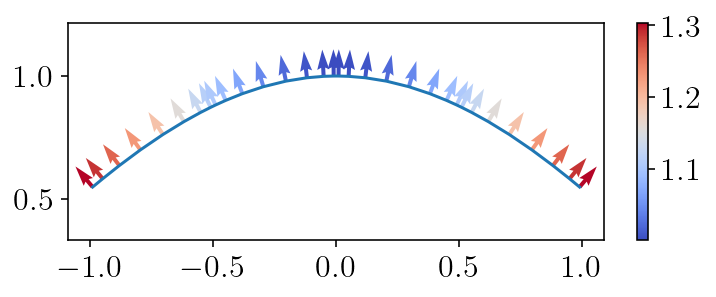

In [3]:
import sympy as sp
from tectosaur2 import panelize_symbolic_surface, gauss_rule

# The definition of the parameterized surface.
sp_t = sp.var("t")
x = sp_t
y = sp.cos(sp_t)

quad_rule = gauss_rule(8)
S = panelize_symbolic_surface(sp_t, x, y, quad_rule, n_panels=4)
print(
    f"The surface has {S.n_panels} panels with {S.panel_order} quadrature points per panel and {S.n_pts} quadrature points total."
)

plt.figure(figsize=(6, 2))
plt.plot(S.pts[:, 0], S.pts[:, 1])
plt.quiver(
    S.pts[:, 0],
    S.pts[:, 1],
    S.normals[:, 0],
    S.normals[:, 1],
    S.jacobians,
    scale=20,
    cmap="coolwarm",
)
plt.axis("equal")
plt.colorbar()
plt.show()

## Barycentric Lagrange interpolation

When we compute a boundary integral, there are two sources of error: 
1. the surface approximation error
2. the quadrature error.

We've been focusing so far on the quadrature error because it can be reduced dramatically with better algorithms, especially in the singular or near-singular case. The surface approximation error is handled simply through using a higher resolution approximation to the surface -- for example, representing a circle with 100 points instead of 50. However, in the rest of this section it will be nice to be able to hold the surface approximation error constant while reducing the quadrature error to zero. But, in the integration techniques we have been using, the quadrature error and the surface error are inextricably linked. When we increase from using 50 to 100 points to integrate a function over a circle, we have been improving both the surface approximation and also using a more accurate quadrature rule.

To separate the two components, we'll interpolate points from a low order surface approximation in order to calculate the locations of quadrature points for a higher order integral approximation. To make the difference more concrete... Before, we would calculate new point locations for a circle by calculating $(cos \theta, sin \theta)$. Now, we will calculate the new point from a polynomial interpolation of the $n$ existing points $\sum_{i}^n c_i p_i(x)$. In some sense, this is also more realistic. In a real-world application, we normally have a data-derived surface representation that we can't improve. On the other hand, even in that real world setting, we *can* add more quadrature points by interpolating on that surface. But adding more quadrature points won't make the surface itself any more accurate.

We won't need to worry directly about interpolation since it's handled internally to `integrate_term` but it's a pretty fundamental component of the numerical methods being used here, so I figured it'd be good to introduce.

We're going to use [barycentric Lagrange interpolation](https://people.maths.ox.ac.uk/trefethen/barycentric.pdf){cite:p}`berrutBarycentricLagrangeInterpolation2004`. I strongly recommend that paper if you've never run into barycentric Lagrange interpolation before!

Since we're integrating and interpolating functions on a finite interval, we'll use a Gaussian quadrature rule for doing the quadrature. As a result, we will be interpolating from the Gauss-Legendre points.

In [4]:
def gauss_rule(n):
    """
    The n-point gauss quadrature rule on [-1, 1].
    Returns tuple of (points, weights)
    """
    k = np.arange(1.0, n)
    a_band = np.zeros((2, n))
    a_band[1, 0 : (n - 1)] = k / np.sqrt(4 * k * k - 1)  # noqa: E203
    x, V = scipy.linalg.eig_banded(a_band, lower=True)
    w = 2 * np.real(np.power(V[0, :], 2))
    return x, w

Below is a little check to make sure our interpolation snippet is working correctly. We interpolate $sin(5x)$ (plotted with a solid black line) on a grid of 7 points (blue dots) and plot the resulting approximate function (red dashes line). This isn't a rigorous check, but it is working! Convergence is very fast if we increase the interpolation order, but I've left out a demonstration of that.

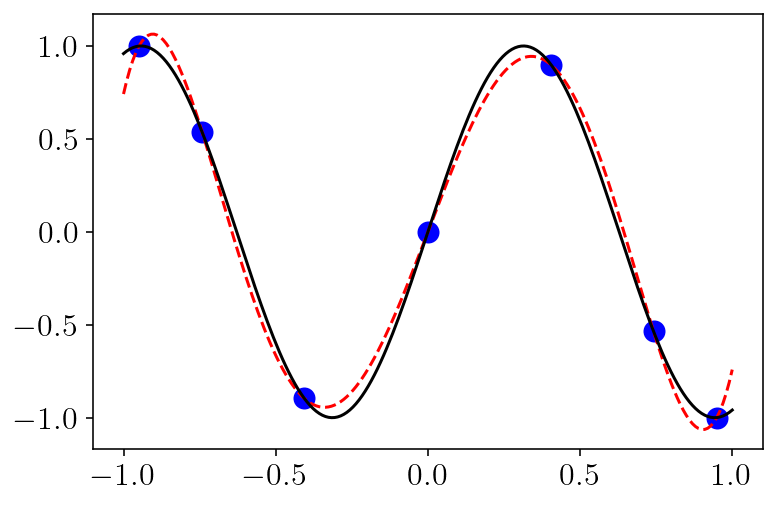

In [5]:
import scipy.interpolate

# First, form the interpolating polynomial
qx, qw = gauss_rule(7)
fqx = np.sin(5 * qx)
I = scipy.interpolate.BarycentricInterpolator(qx, fqx)

# Then, evaluate the polynomial at a bunch of points for plotting.
xs = np.linspace(-1, 1, 200)
v = I(xs)

plt.plot(qx, fqx, "bo", markersize=10)
plt.plot(xs, v, "r--")
plt.plot(xs, np.sin(5 * xs), "k-")
plt.show()

## Hypersingular stress integrals

Integrals as functions: I think it's useful to think about the integrals in integral equations as functions accepting a certain input and producing a certain output. For example, the double layer integral accepts a potential input (and a set of observation points and a source surface mesh) and produces a potential as output. In comparison, the hypersingular integral accepts a potential input and produces a potential gradient as output. The input is the same, but the output has had an extra derivative applied. In terms of antiplane elasticity, potential is displacement and potential gradient is stress. The API of the `integrate_term` function is intended to closely match this integrals-as-functions concept where the three main parameters are the kernel function, the observation points and the source surface.

The second missing piece is a set of tools for computing stresses in the volume given an input fault slip. Continuing in the antiplane strain setting, what we want is to compute the gradient of displacement times the shear modulus.

\begin{equation}
(\sigma_{xz}, \sigma_{yz}) = (\mu \frac{\partial \phi}{\partial x}, \mu \frac{\partial \phi}{\partial y})
\end{equation}

```{margin}
As a reminder, By "naive integrator", I just mean the non-QBX integration function that would be the equivalent of the `double_layer_matrix` function from the previous section. This is equivalent to "directly" integrating the integral equation. (it might be good to be more consistent about these terms?)
```

The hypersingular integral will computes $\sigma_{xz}$ and $\sigma_{yz}$ for us given the source slip distribution. Since, we already built all the components of a QBX algorithm for the double layer case, we can now just write the naive integrator for a new kernel and everything works perfectly. In the cell below, I've implemented a naive integrator for the hypersingular integral.

Why is this kernel called "hypersingular"? Because the kernel behaves like $O(\frac{1}{r^2})$ in 2D. This makes the integral especially difficult for many traditional integration methods. As you'll see below, this is not a barrier for QBX and we are able to calculate the integral extremely accurately even right on the surface.

```{note}
A quick summary of the common types of singular integrand behavior:
- **Weakly singular**: the integrand behaves like $O(log(r))$ in 2D. When we integrate a weakly singular integral over a surface, the integral is well-defined in the normal sense.
- **Strongly singular**: The double layer potential is strongly singular. The integrand behaves like $O(\frac{1}{r})$ in 2D. When we integrate a strongly singular integral over a surface, the integral must be defined in the Cauchy principal value sense. Otherwise, the integral is divergent (more or less equal to infinity). However, when the integral is computed as an interior limit, the value is well defined because no integral along the limiting path is ever actually singular.
- **Hypersingular**: The integrand behaves like $O(\frac{1}{r^2})$. The integral is so divergent that it's not even well-defined in the Cauchy principal value sense. Like strongly singular integrals, computing as an interior limit works out well.
```

In [6]:
def hypersingular(obs_pts, src_pts, src_normals):
    dx = obs_pts[:, 0, None] - src_pts[None, :, 0]
    dy = obs_pts[:, 1, None] - src_pts[None, :, 1]
    r2 = dx ** 2 + dy ** 2

    A = 2 * (dx * src_normals[None, :, 0] + dy * src_normals[None, :, 1]) / r2
    C = -1.0 / (2 * np.pi * r2)

    out = np.empty((obs_pts.shape[0], 2, src_pts.shape[0]))

    # The definition of the hypersingular kernel.
    # unscaled sigma_xz component
    out[:, 0, :] = src_normals[None, :, 0] - A * dx
    # unscaled sigma_xz component
    out[:, 1, :] = src_normals[None, :, 1] - A * dy

    return out * C[:, None, :, None]

```{margin}
By leaving out the shear modulus, I'm implicitly assuming that $\mu = 1$. You can just imagine that we're solving a nondimensionalized version of the problem. This is quite common because scaling the displacement and stress to lie in a similar range of values can improve the numerical conditioning of some problems.
```

## General purpose interior evaluation

Here, we'll write a pretty big function that is going to produce nice figures for comparing QBX against a naive computation. The function is written to be independent of the surface and kernel function. Please look through the function! Very little is new compared to the previous section. We're just applying the tools we've already built or used.

In [7]:
import warnings
from tectosaur2 import integrate_term, pts_grid, gauss_rule, upsample
from tectosaur2.laplace2d import double_layer, hypersingular
def qbx_example(kernel, surface, n_panels, vmin=None, vmax=None):
    warnings.filterwarnings("ignore")

    def slip_fnc(xhat):
        # This must be zero at the endpoints for potential gradient to be finite.
        # return np.ones_like(xhat)
        return np.cos(xhat * np.pi) + 1.0

    surface_low = panelize_symbolic_surface(*surface, gauss_rule(10), n_panels=n_panels)
    slip_low = slip_fnc(surface_low.quad_pts)

    nobs = 400
    zoomx = [-1.5, 1.5]
    zoomy = [-1.5, 1.5]
    xs = np.linspace(*zoomx, nobs)
    ys = np.linspace(*zoomy, nobs)
    obs_pts = pts_grid(xs, ys)

    low_vals = (
        kernel.direct(obs_pts, surface_low)[:, 0, :, 0]
        .dot(slip_low)
        .reshape((nobs, nobs))
    )

    # This step is NEW! We're upsampling a surface by interpolating the data and
    # surface discretization to a finer grid. This will help get better results
    # out of the naive integrator.
    surface_high, interp_mat = upsample(surface_low, 5)
    slip_high = interp_mat.dot(slip_low)
    high_vals = (
        kernel.direct(obs_pts, surface_high)[:, 0, :, 0]
        .dot(slip_high)
        .reshape((nobs, nobs))
    )

    singularities = np.array(
        [
            [surface[1].subs(surface[0], -1), surface[2].subs(surface[0], -1)],
            [surface[1].subs(surface[0], 1), surface[2].subs(surface[0], 1)],
        ]
    )
    qbx_vals = (
        integrate_term(
            kernel, obs_pts, surface_low, tol=1e-10, singularities=singularities
        )[:, 0, :, 0]
        .dot(slip_low)
        .reshape((nobs, nobs))
    )

    if vmin is None:
        vmin = -1.0
    if vmax is None:
        vmax = 1.0
    levels = np.linspace(vmin, vmax, 11)

    obsx = obs_pts[:, 0].reshape((nobs, nobs))
    obsy = obs_pts[:, 1].reshape((nobs, nobs))

    plt.figure(figsize=(16, 12))
    plt.subplot(2, 3, 1)
    plt.title("Naive solution")
    cntf = plt.contourf(obsx, obsy, low_vals, levels=levels, extend="both")
    plt.contour(
        obsx,
        obsy,
        low_vals,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    plt.plot(surface_high.pts[:, 0], surface_high.pts[:, 1], "k-", linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)

    plt.subplot(2, 3, 2)
    plt.title("Upsampled naive solution")
    cntf = plt.contourf(obsx, obsy, high_vals, levels=levels, extend="both")
    plt.contour(
        obsx,
        obsy,
        high_vals,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    plt.colorbar(cntf)
    plt.plot(surface_high.pts[:, 0], surface_high.pts[:, 1], "k-", linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)

    plt.subplot(2, 3, 3)
    plt.title("Naive error")
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        logerror = np.log10(np.abs(low_vals - high_vals))
    logerror[np.isinf(logerror)] = -12.0
    cntf = plt.contourf(
        obsx, obsy, logerror, levels=np.linspace(-12, 0, 13), extend="both"
    )
    plt.contour(
        obsx,
        obsy,
        logerror,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=np.linspace(-12, 0, 13),
        extend="both",
    )
    cb = plt.colorbar(cntf)
    cb.set_label(r"$\log_{10}(|\hat{u} - \hat{u}_{\textrm{naive}}|)$", fontsize=14)
    plt.plot(surface_high.pts[:, 0], surface_high.pts[:, 1], "k-", linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.tight_layout()

    plt.subplot(2, 3, 4)
    plt.title("QBX solution")
    cntf = plt.contourf(obsx, obsy, qbx_vals, levels=levels, extend="both")
    plt.contour(
        obsx,
        obsy,
        qbx_vals,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    plt.plot(surface_high.pts[:, 0], surface_high.pts[:, 1], "k-", linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)

    plt.subplot(2, 3, 5)
    plt.title("Upsampled naive solution")
    cntf = plt.contourf(obsx, obsy, high_vals, levels=levels, extend="both")
    plt.contour(
        obsx,
        obsy,
        high_vals,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    plt.colorbar(cntf)
    plt.plot(surface_high.pts[:, 0], surface_high.pts[:, 1], "k-", linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)

    plt.subplot(2, 3, 6)
    plt.title("Upsampled naive error")
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        logerror = np.log10(np.abs(qbx_vals - high_vals))
    logerror[np.isinf(logerror)] = -12.0
    cntf = plt.contourf(
        obsx, obsy, logerror, levels=np.linspace(-12, 0, 13), extend="both"
    )
    plt.contour(
        obsx,
        obsy,
        logerror,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=np.linspace(-12, 0, 13),
        extend="both",
    )
    cb = plt.colorbar(cntf)
    cb.set_label(r"$\log_{10}(|\hat{u} - \hat{u}_{\textrm{QBX}}|)$", fontsize=14)
    plt.plot(surface_high.pts[:, 0], surface_high.pts[:, 1], "k-", linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.tight_layout()
    plt.show()

## Displacement from a line source

For the remainder of this part, we'll compute displacements and stresses for a three simple geometries of increasing difficulty.

For each plot, there will be a geometry summary that's just a black line showing the location of the "fault" and red dots showing the location of the QBX expansions.

Then, we'll plot three solutions: the naive solution, a high accuracy naive solution (from 2000 points) and a QBX solution. We'll also plot the $\log_{10}$ error for both the naive and QBX solutions.

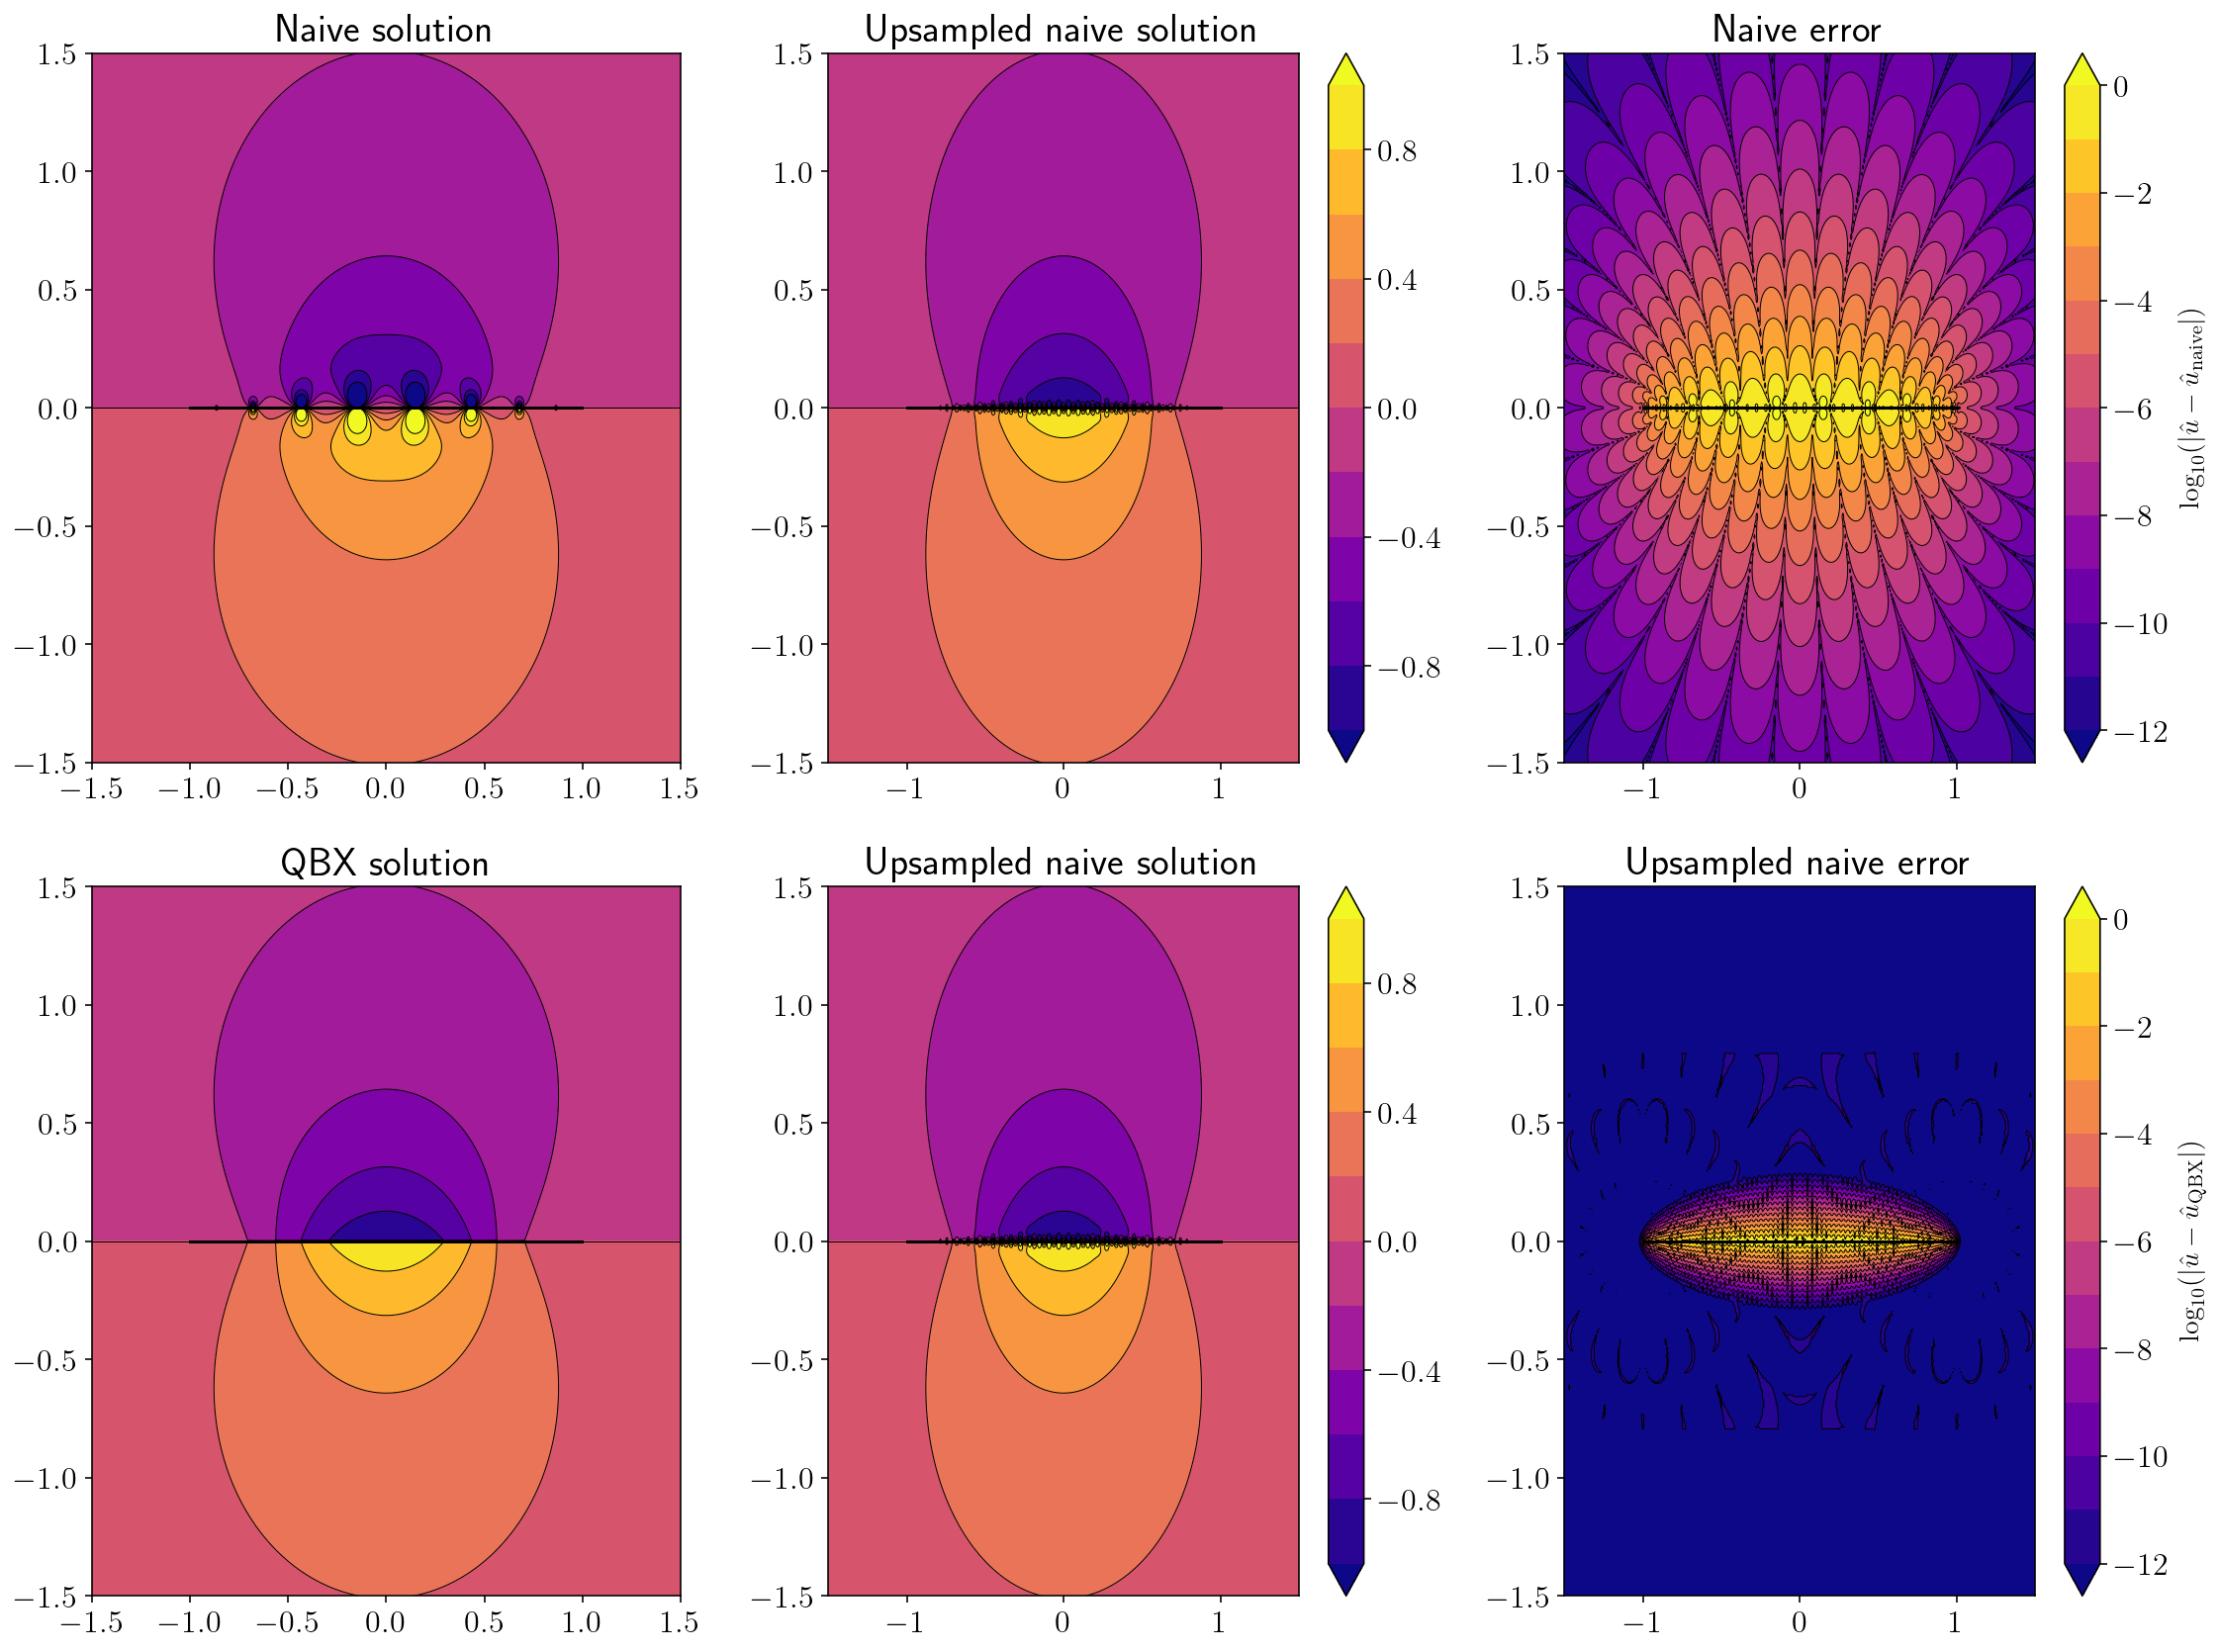

In [8]:
qbx_example(double_layer, (sp_t, sp_t, 0*sp_t), 1)

## Stress from a line source

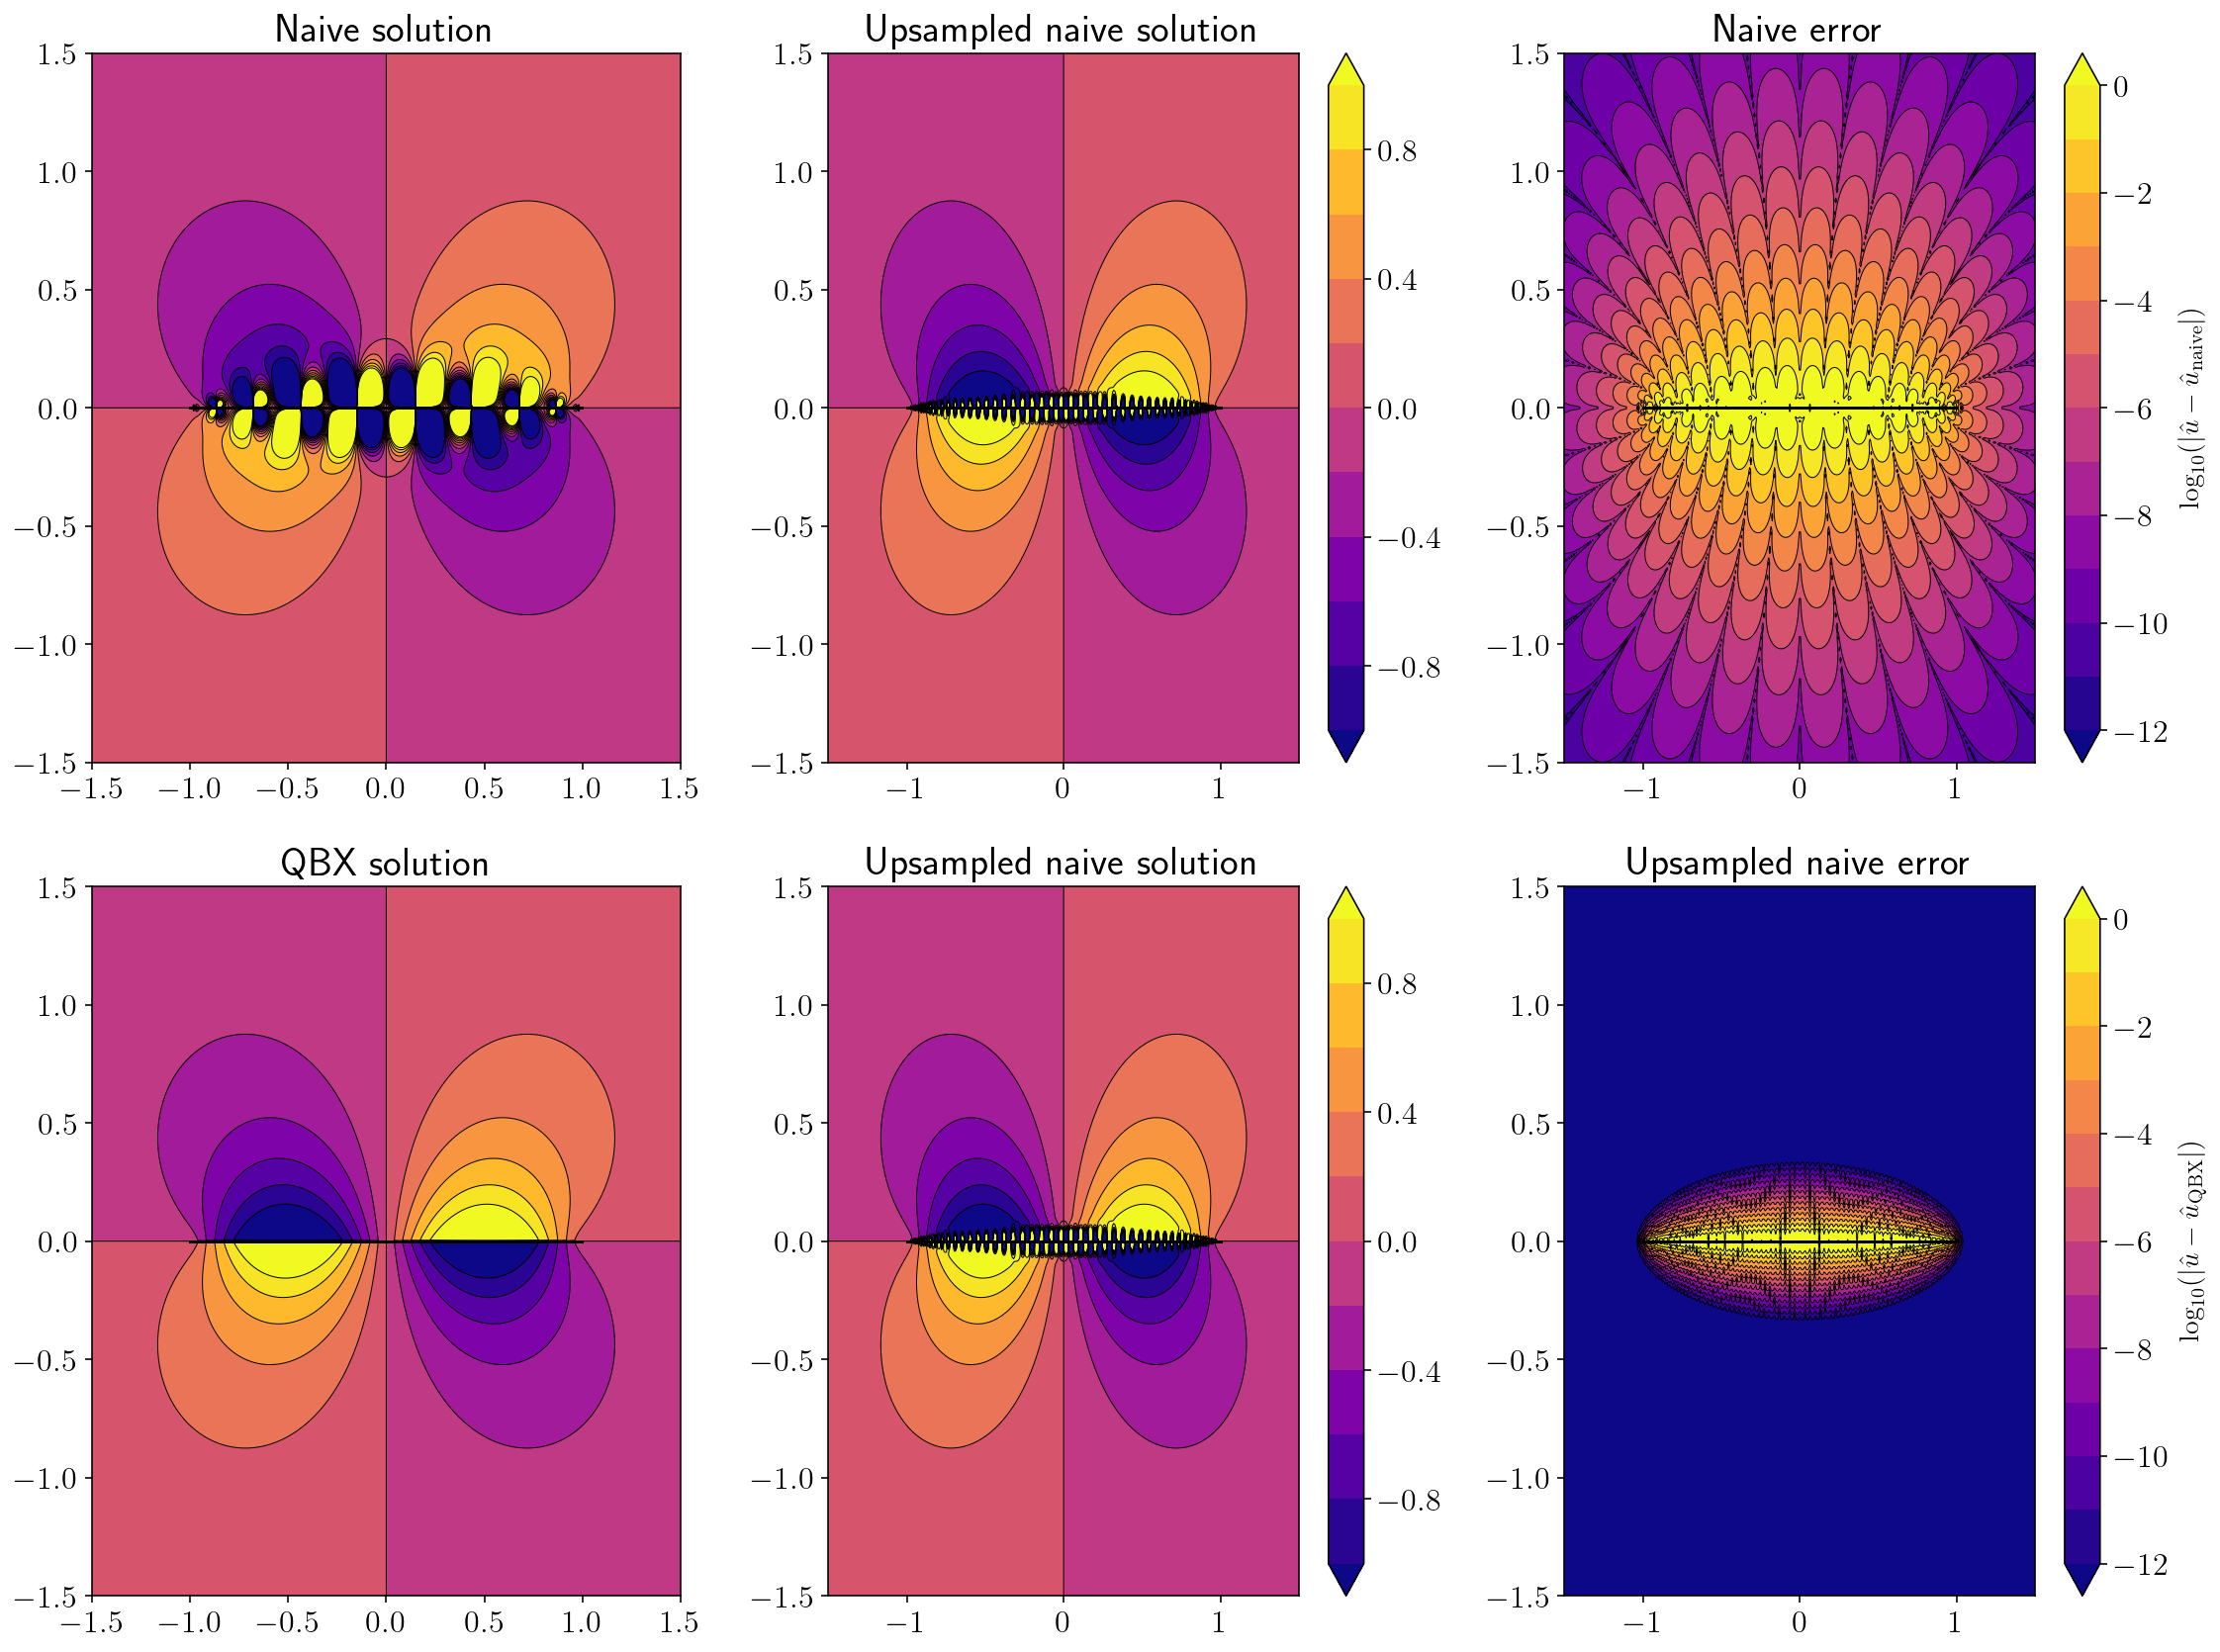

In [9]:
qbx_example(hypersingular, (sp_t, sp_t, 0*sp_t), 1)

## Displacement from an arc source

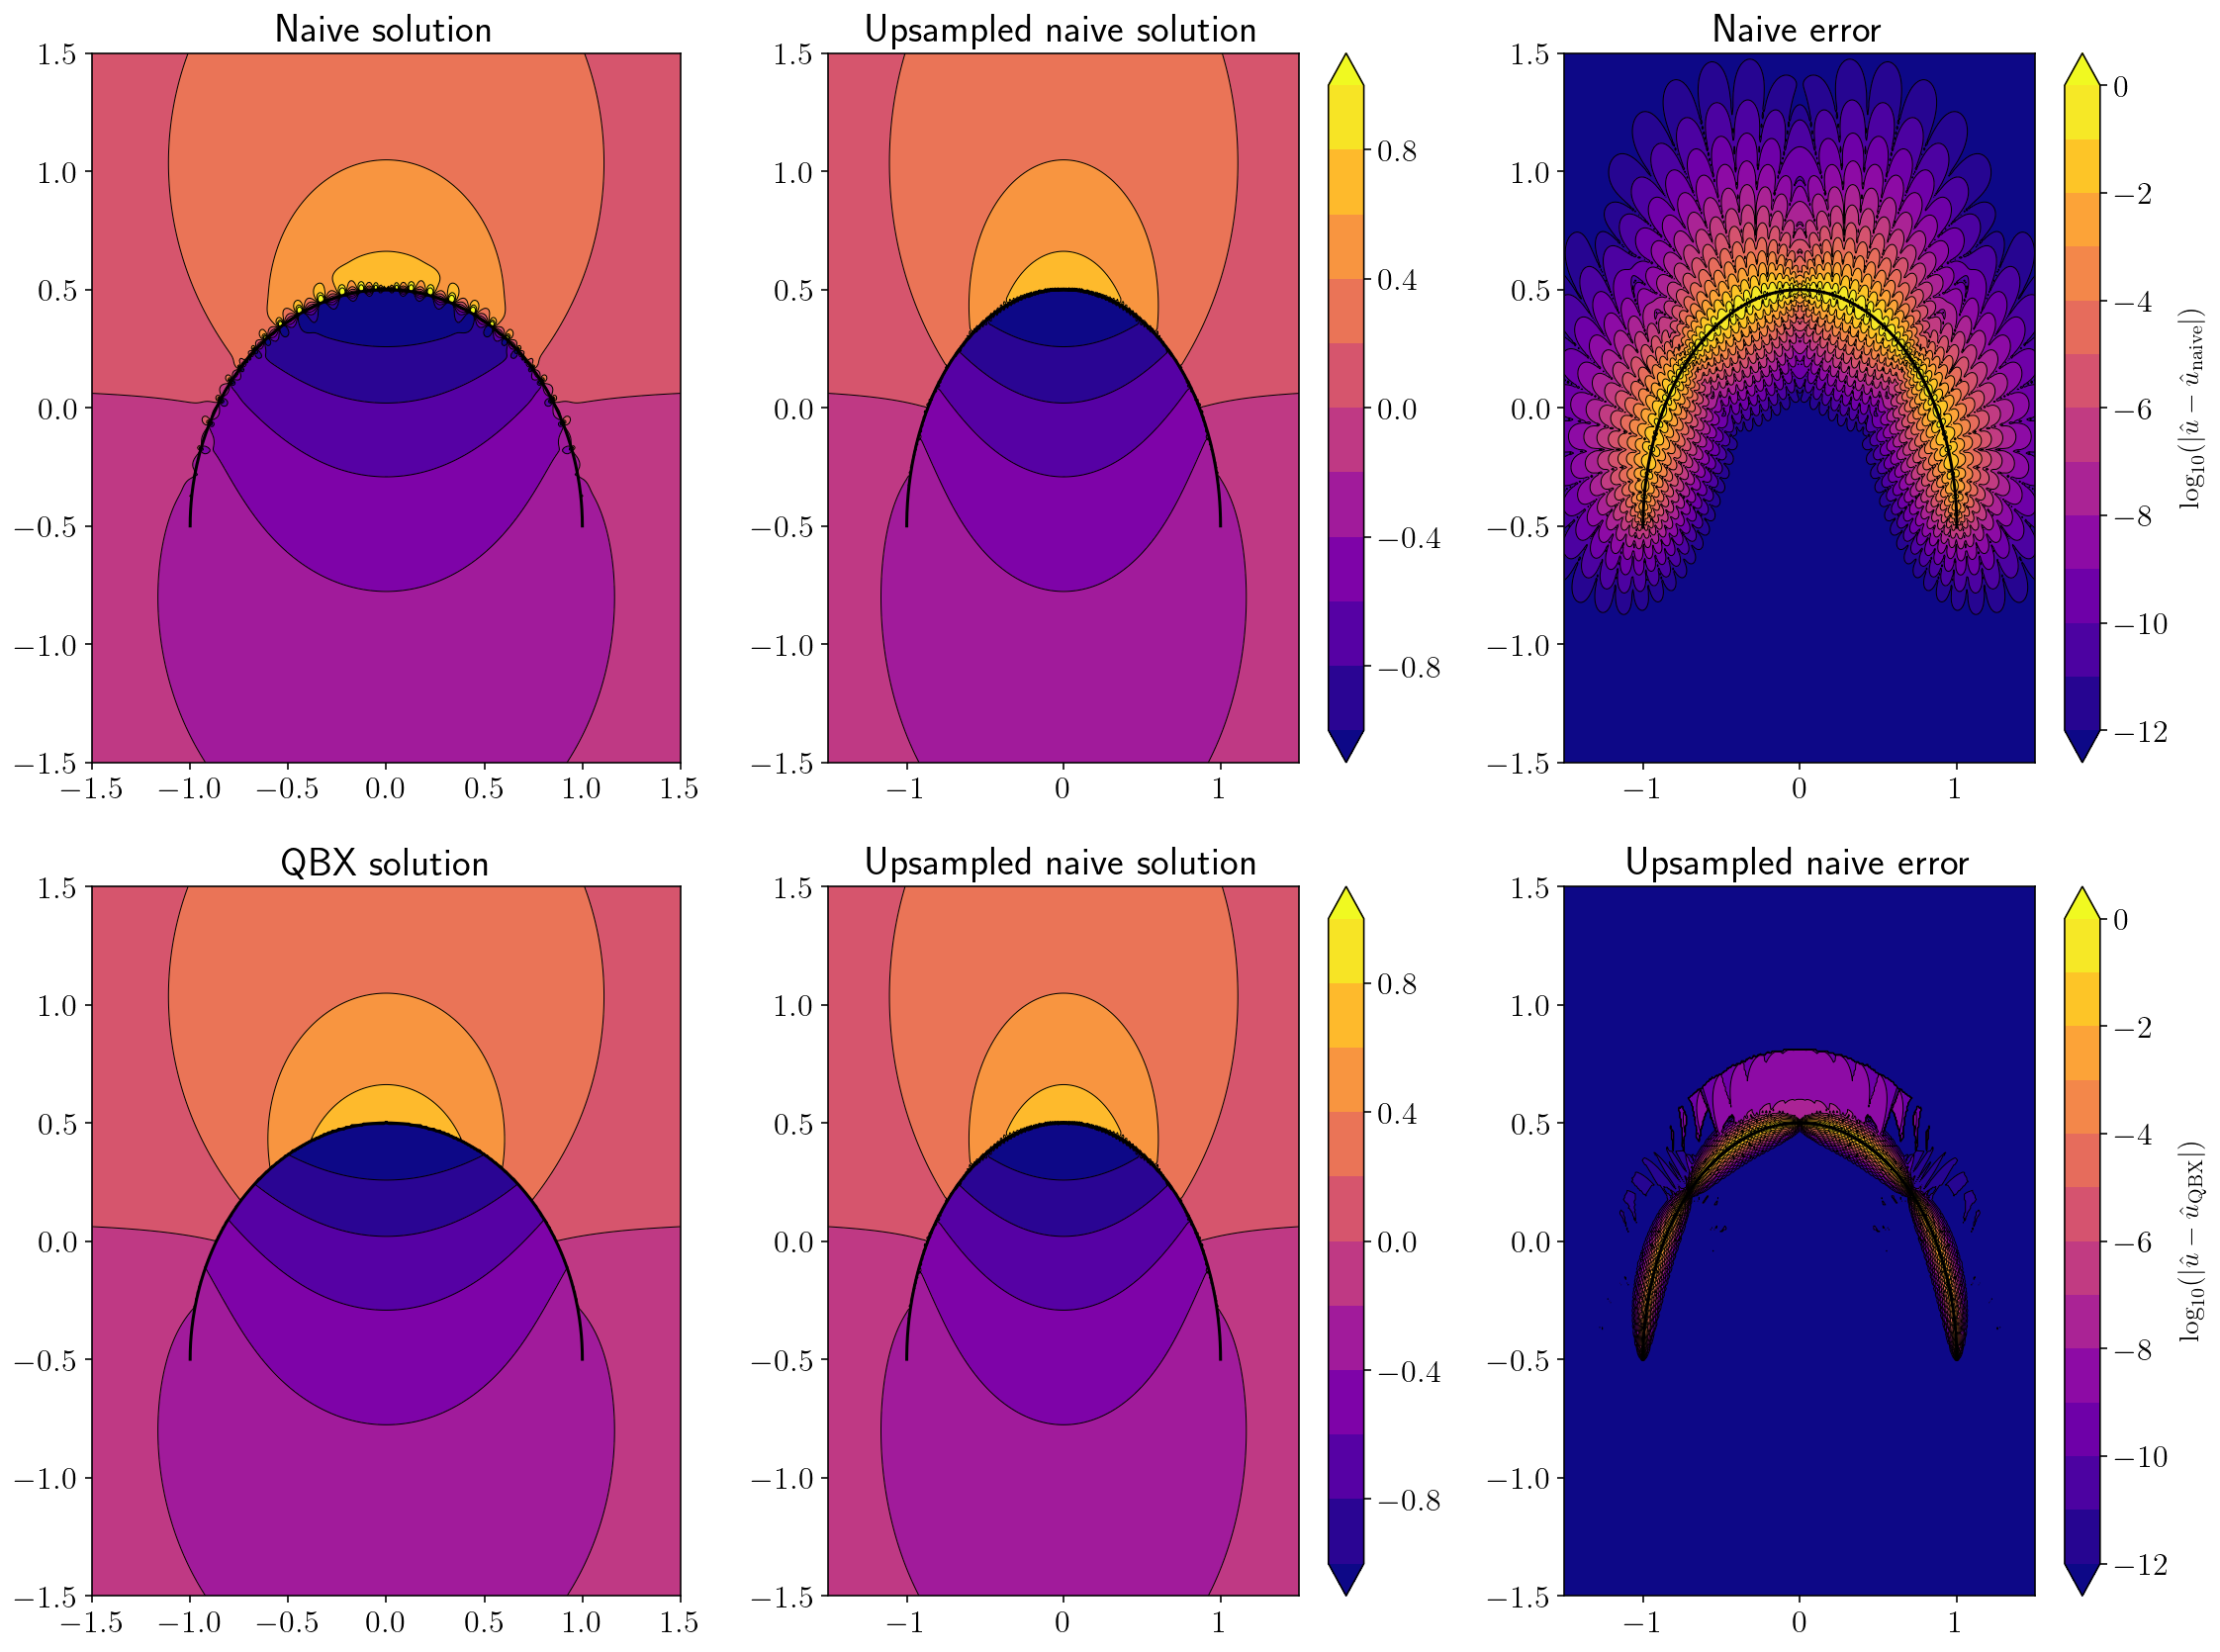

In [10]:
sp_t = sp.var('t')
theta = 0.5 * sp_t * sp.pi + 0.5 * sp.pi
x = sp.cos(theta)
y = sp.sin(theta) - 0.5
arc = (sp_t, x, y)
qbx_example(double_layer, arc, 4)

## Stress from an arc source

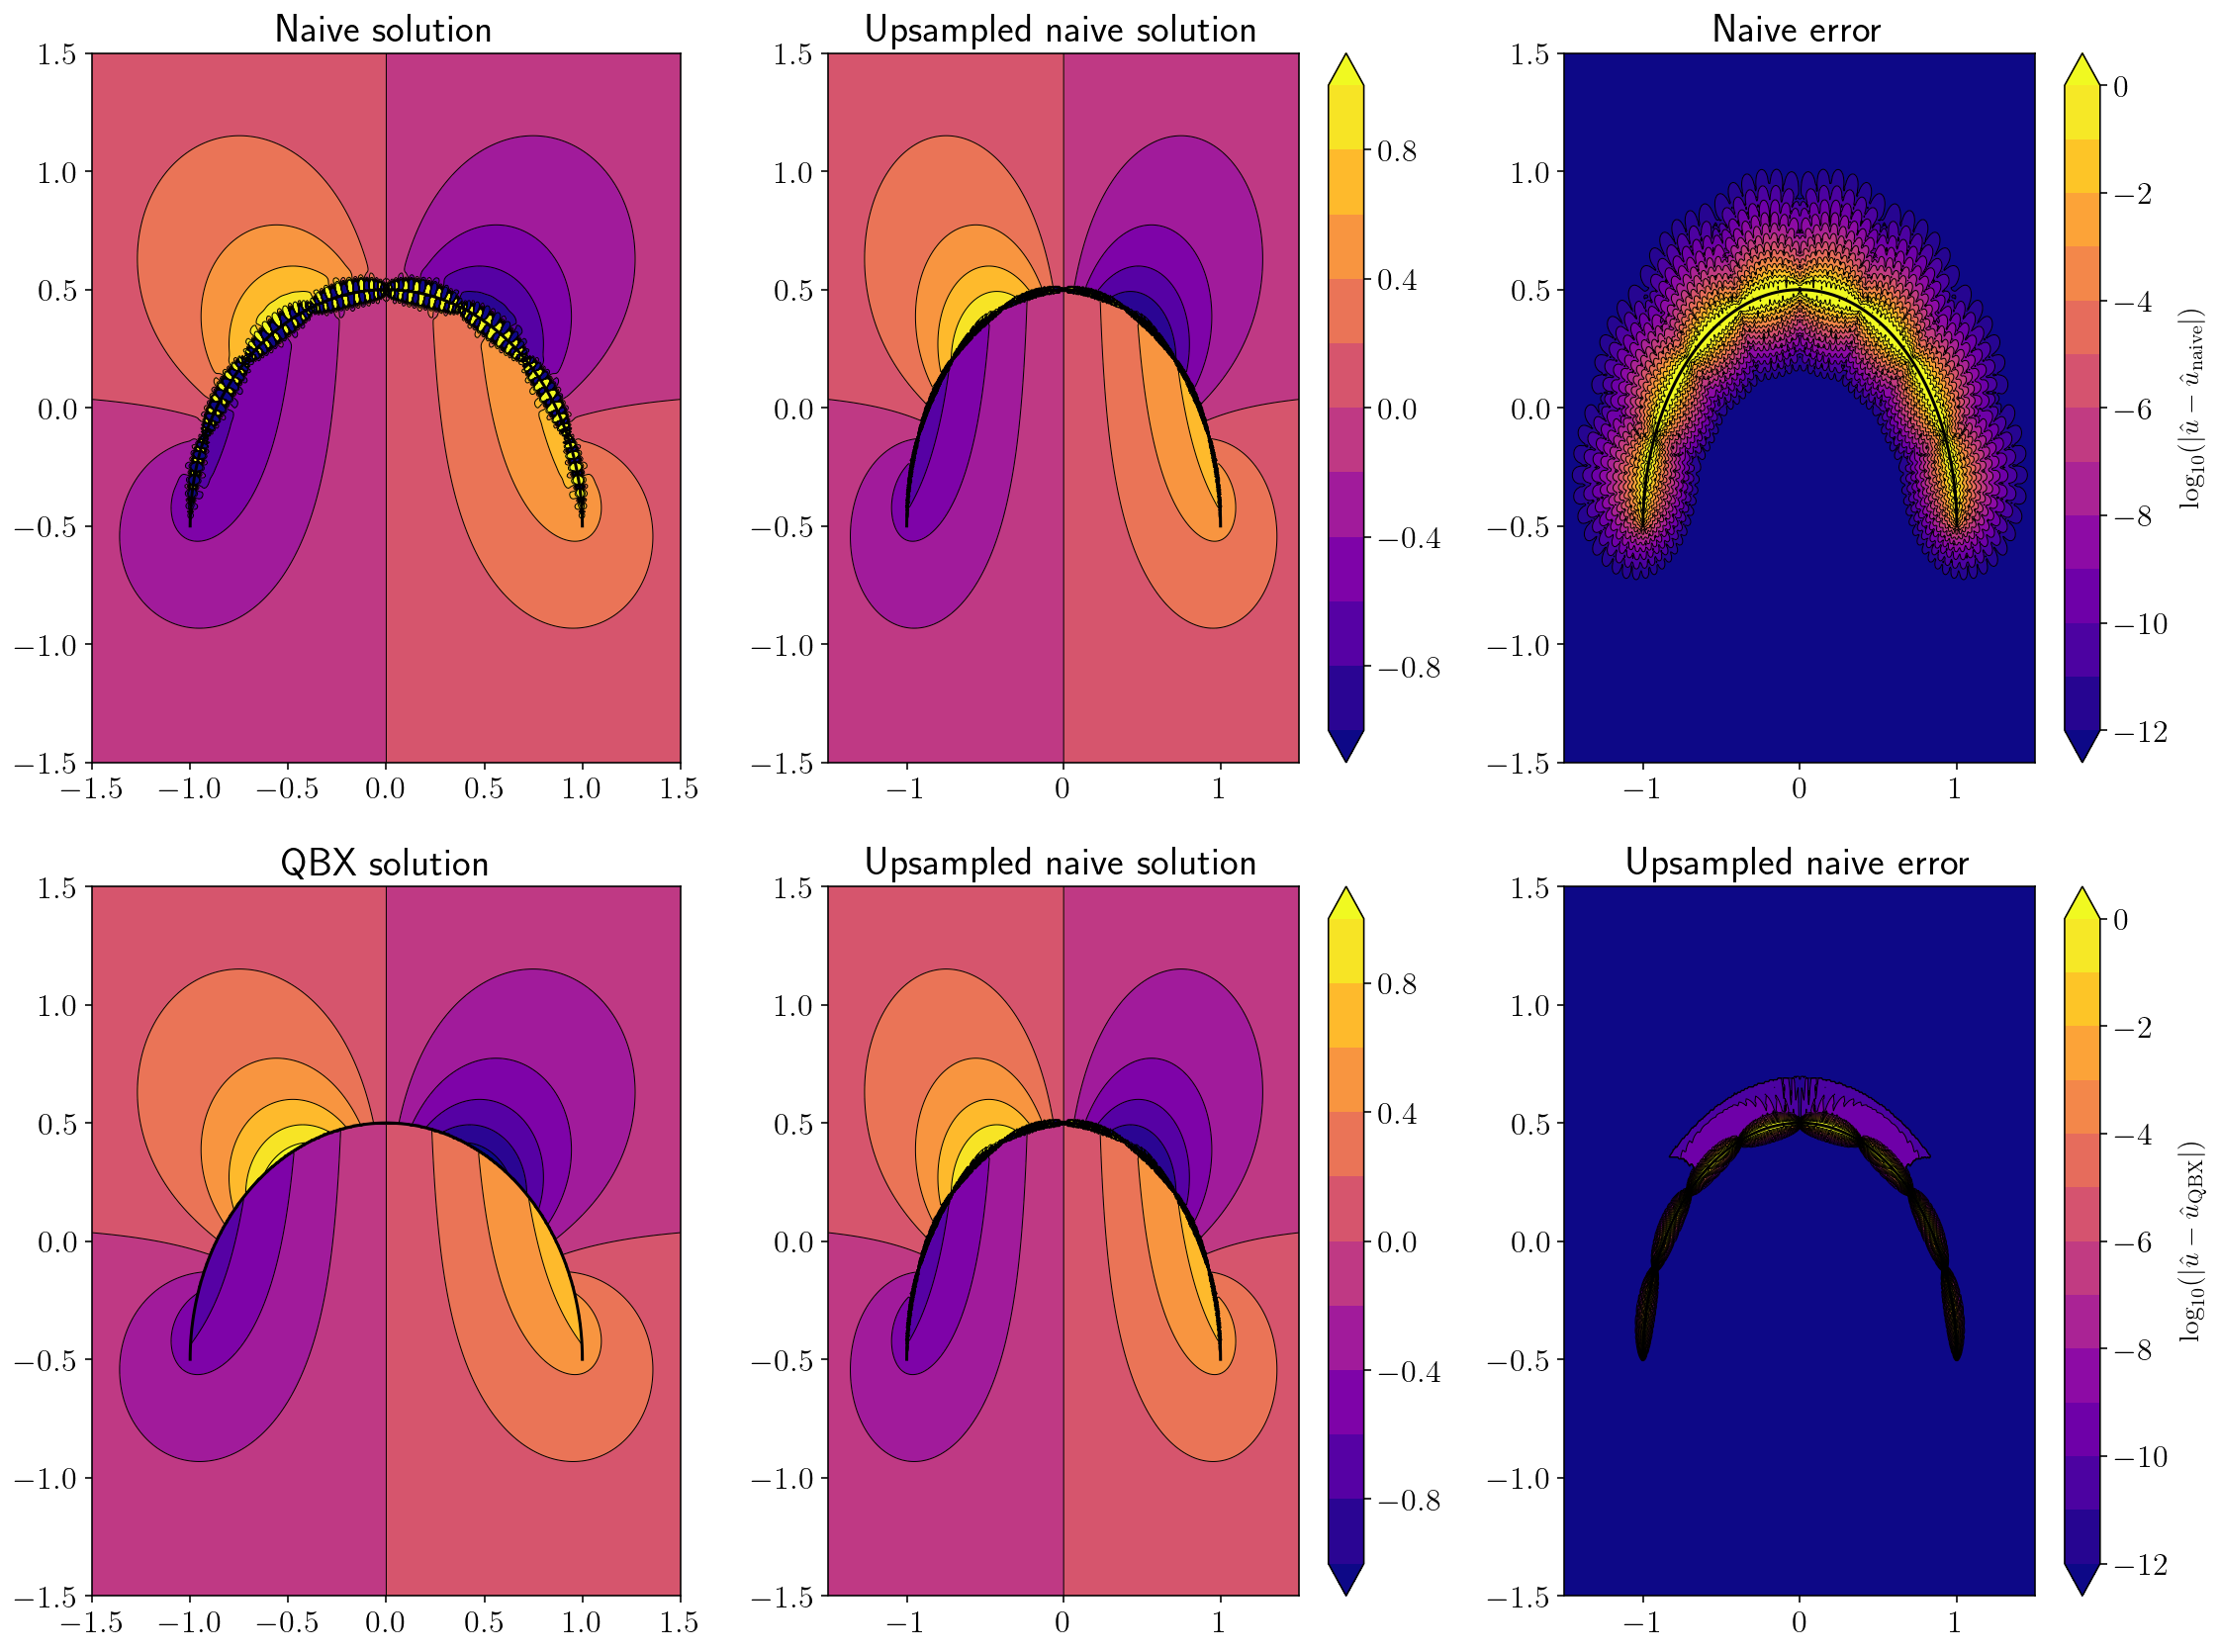

In [11]:
qbx_example(hypersingular, arc, 8)

## Displacement from a challenging wavy source

In [12]:
sp_t = sp.var('t')
x, y = sp_t, sp.sin((sp_t + 1) * 2 * sp.pi)
wavy = (sp_t, x, y)

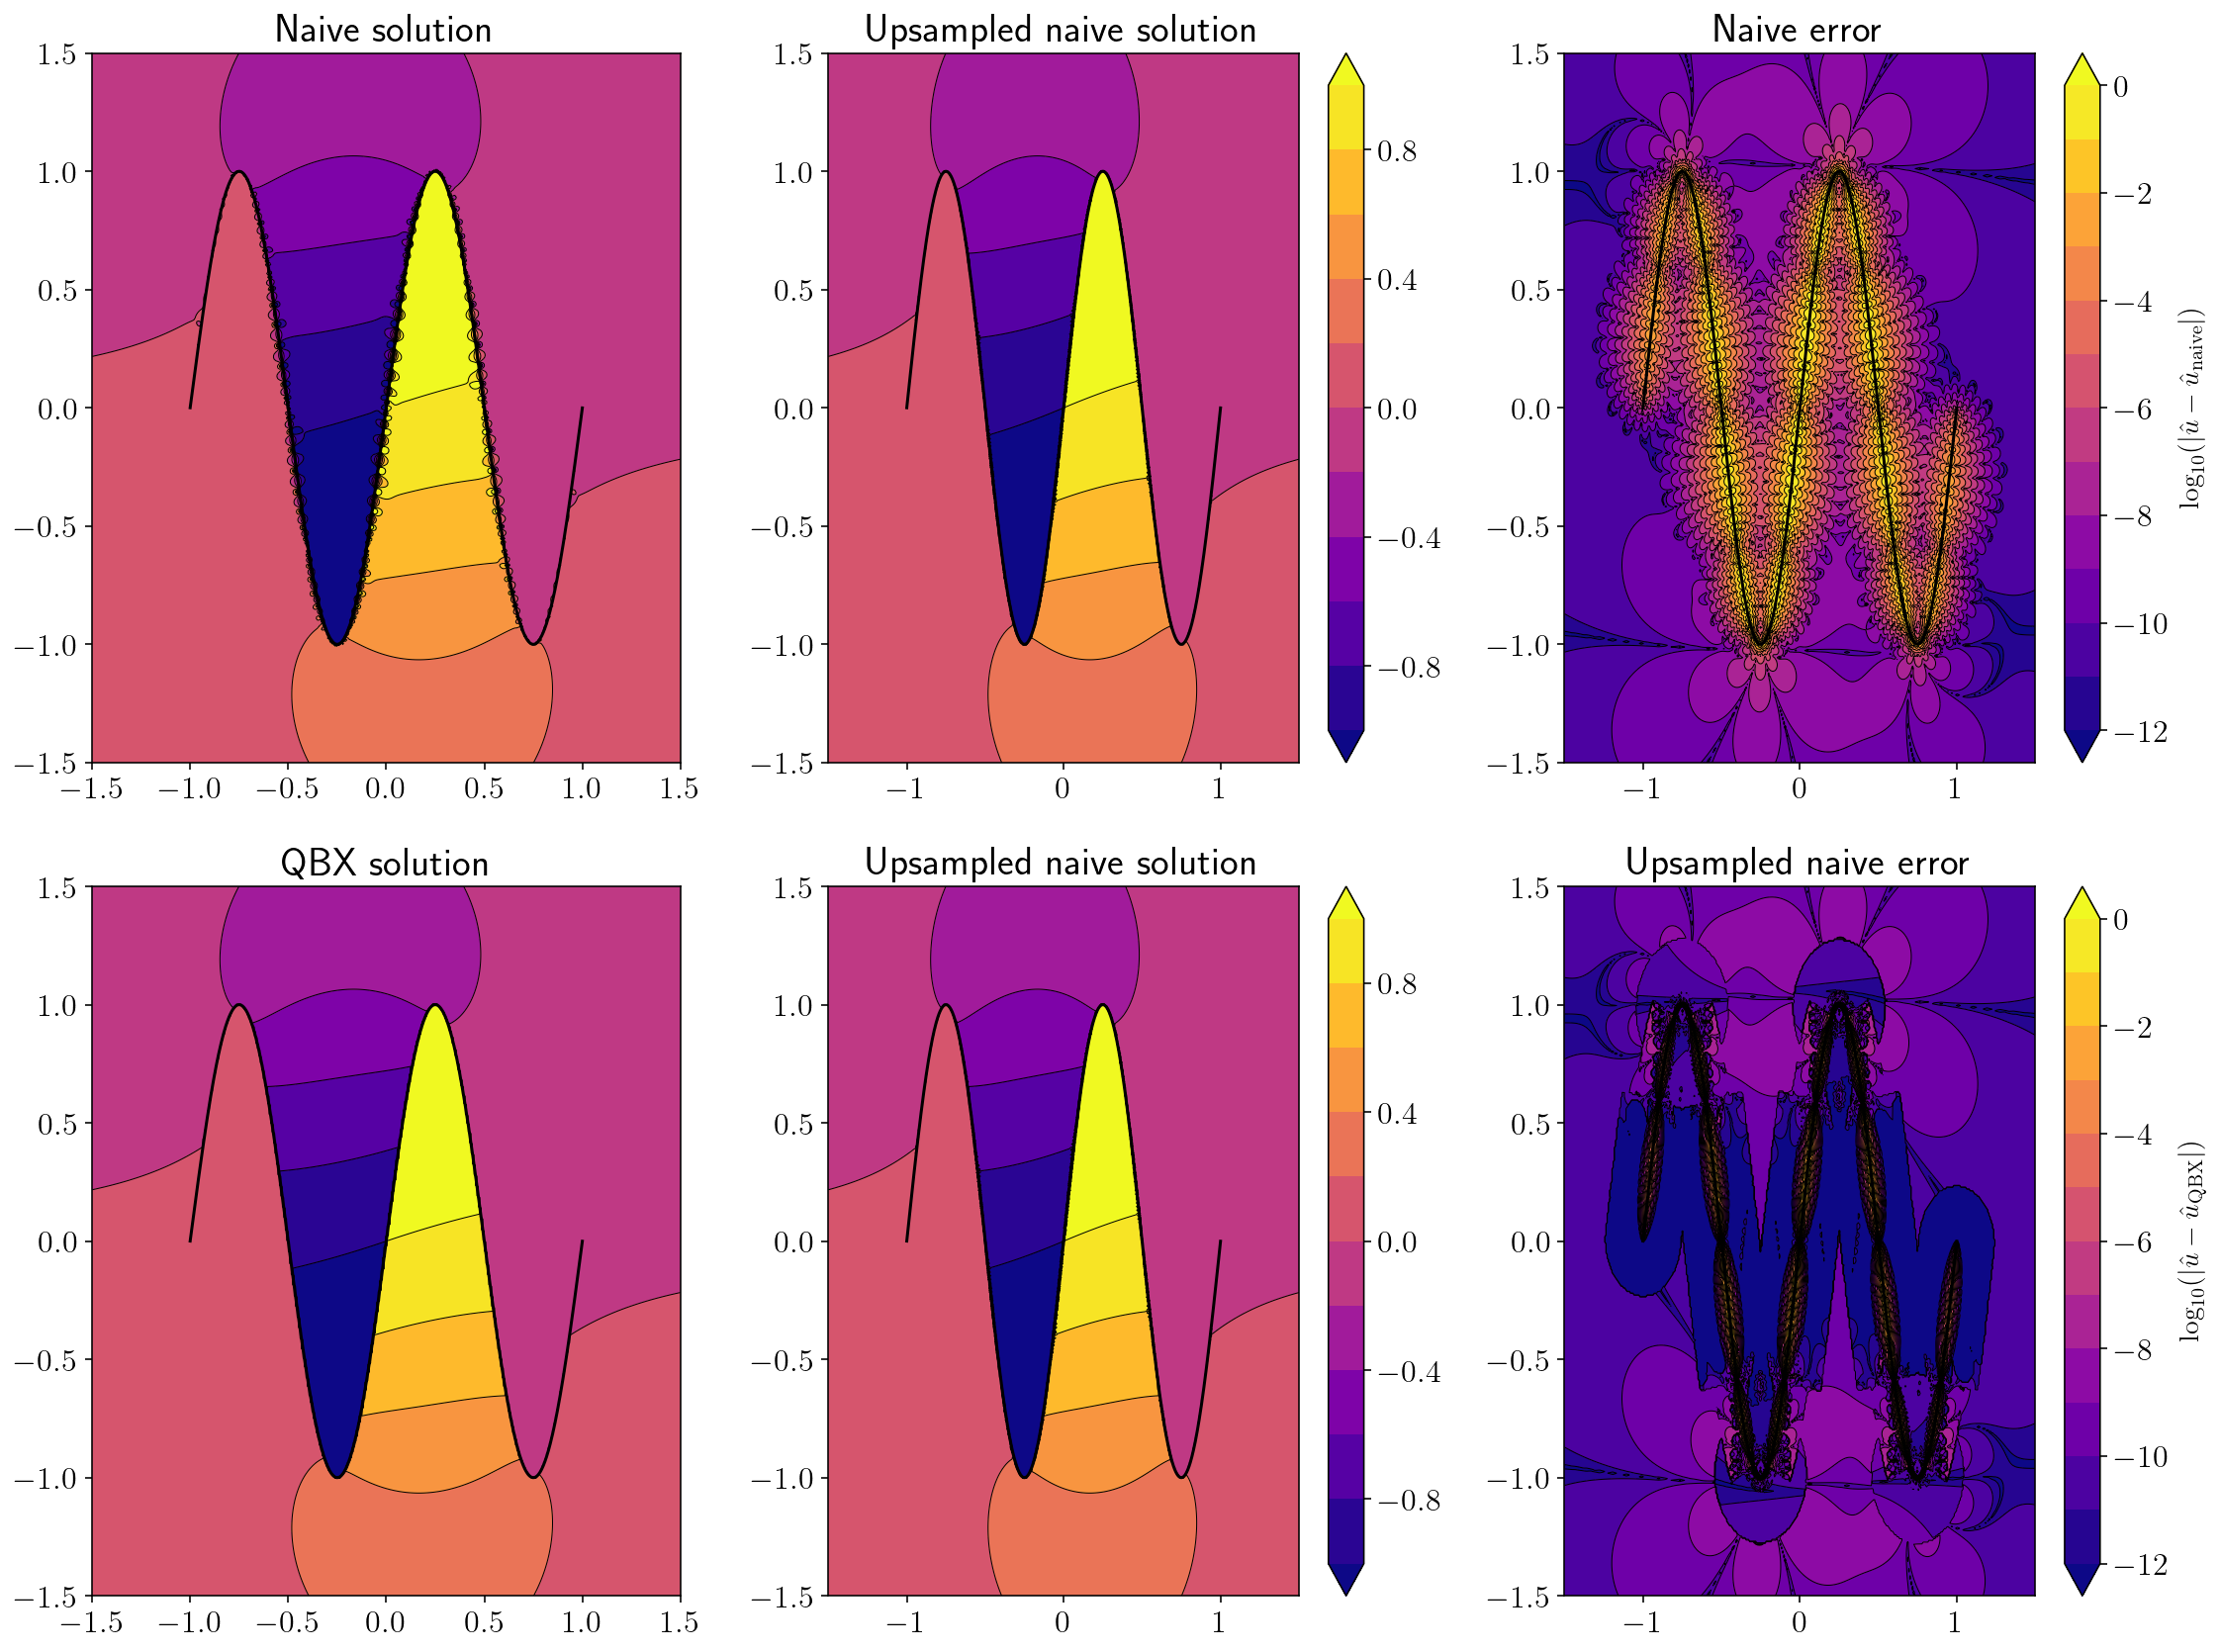

In [15]:
qbx_example(double_layer, wavy, n_panels=20)

## Stress from a challenging wavy source

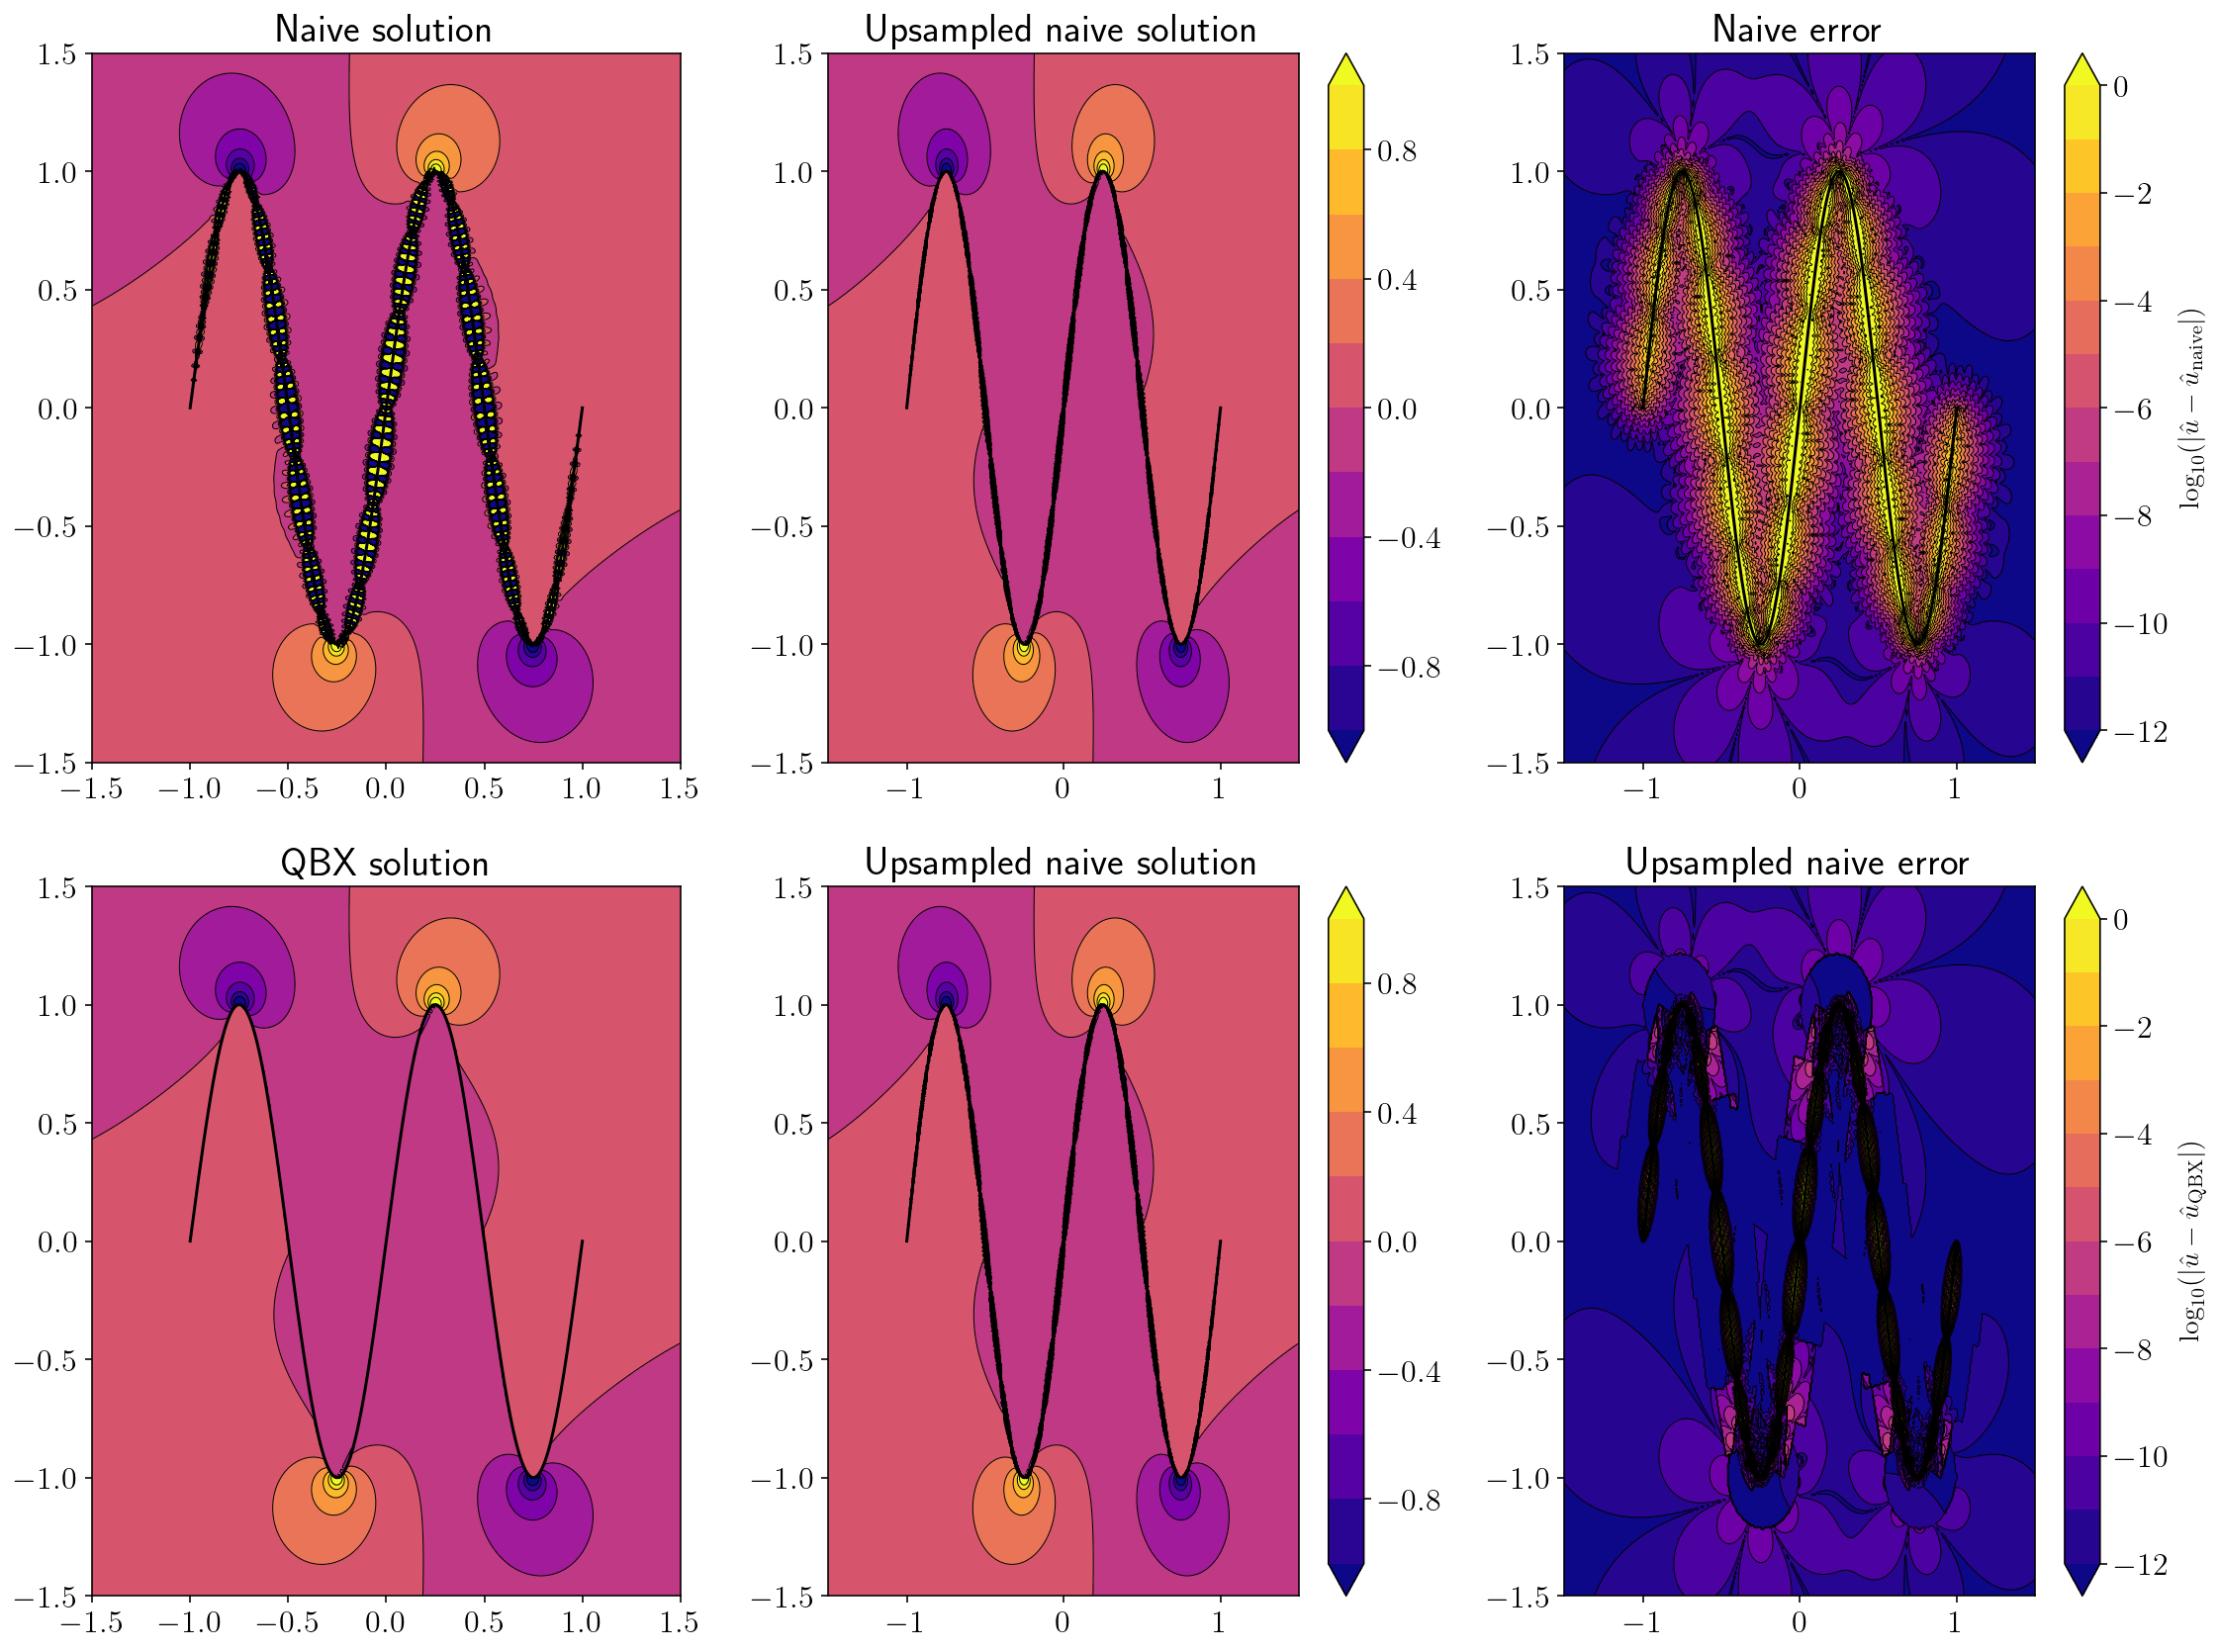

In [16]:
qbx_example(hypersingular, wavy, 30)